# Teen mental health and social media – Back of the envelope calculations
Major depressive episodes among teen girls have increased by 52%, from 13% in 2005 to 20% in 2017 ([Twenge, et al. 2020](https://prcp.psychiatryonline.org/doi/10.1176/appi.prcp.20190015)). Many reseachers believe social media is the primary cause ([Haidt & Twenge](https://docs.google.com/document/d/1w-HOfseF2wF9YIpXwUUtP65-olnkPyWcgF5BiAtBEy0/edit)).

However, some researchers say that the correlation between social media use and well-being is small ([Orben & Przybylski, 2019](https://www.nature.com/articles/s41562-018-0506-1)). The correlation between overall screen time and well-being is -0.05. When narrowing down to social media and girls, the correlation is -0.20, which some may still [describe](https://en.wikipedia.org/wiki/Effect_size) as 'small'.

In this notebook, I use a simple linear+threshold model to show that a correlation of 0.20 in girls is _more than enough_ to explain the 52% increase in depression since 2005. The intuition is that a small change in a slope can have a big effect on the tails of a distribution. 

### Basic overview
The purpose of this model is _not_ to precisely quantify the relationship between social media use and depression. Rather, the purpose is to show that as a ballpark estimate an r=0.20 correlation can roughly account for the 52% increase in depression. As such, I made the simplest possible assumptions. 
* Well-being is normally distributed. (The scale doesn't matter)
* 4 hours of social media per day with a light rightward skew in the distribution. (Scale and shape don't matter too much)
* Well-being is a linear function of social media use.
* Depression occurs when well-being falls below a threshold. The threshold was chosen such that the depression rate was 13% (the baseline in 2005) without social media.

### Results
Using the simple linear+threshold model, a correlation of 0.20 would increase depression rates in girls from a baseline of 13% to a new value 24%, which actually exceeds the value observed in [Twenge, et al. (2020)](https://prcp.psychiatryonline.org/doi/10.1176/appi.prcp.20190015). The intuition is that a small increase in a correlation can cause a large _relative_ change in the percentage of tail points that exceed a threshold.


### Commentary on the assumptions
One could further refine the assumptions, which would variously strengthen or weaken the size of the effect.
* Allowing noise in depression diagnoses, rather than a hard threshold, would weaken the effect.
* Adding [nonlinearities](https://doi.org/10.1038/s41562-020-0839-4) would strengthen the effect.
* Adding [network effects](https://chris-said.io/2021/08/14/teens-loneliness-social-media/) would strengthen the effect.




In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
blue='#3ac3f2'
pink='#ed2685'

In [142]:
n = 100000
hours = np.random.gamma(4, 1, size=n)

#### Assumptions about hours of social media per day
My results are fairly robust to reasonable changes to the shape and size of this distribution.

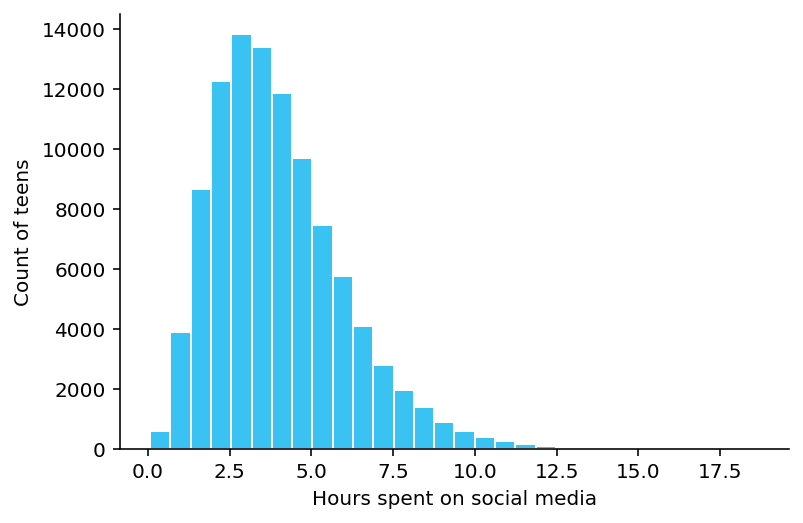

In [143]:
plt.hist(hours, bins=30, facecolor=blue, edgecolor='w');
plt.xlabel('Hours spent on social media')
plt.ylabel('Count of teens')
sns.despine()

### Create well-being distributions; and fit a slope and threshold to known data

In [144]:
baseline_scores = np.random.randn(n)

In [215]:
BETA = -0.1 # hand picked to give a -0.20 correlation
new_scores = baseline_scores + BETA * hours
r = np.corrcoef(hours, new_scores)[0,1]
print(f'Correlation (r) between hours spent on social media and well-being: {r:.2f}')

Correlation (r) between hours spent on social media and well-being: -0.20


In [210]:
cutoff = np.percentile(baseline_scores, 13) # based on 13% depression in 2005

In [214]:
baseline_rate = (baseline_scores<cutoff).mean()
print(f'Depression rates at baseline: {baseline_rate:.2f}')

Depression rates at baseline: 0.13


In [213]:
new_rate = (new_scores<cutoff).mean()
print(f'Depression rates with social media: {new_rate:.2f}')

Depression rates with social media: 0.24


# Plots

In [174]:
df = pd.DataFrame({
    'baseline_score': baseline_scores,
    'new_score': new_scores,
    'hours': hours,
}).sample(3000) # downsample so plots are less crowded

In [204]:
mx_hours = 14
mx_score = max(df['baseline_score'].max(), df['new_score'].max()) * 1.35
mn_score = min(df['baseline_score'].min(), df['new_score'].min()) * 1.05

In [205]:
def make_scatter(df, ycolumn, ylabel='Well-being', beta=0, title=' '):
    plt.scatter(df['hours'], df[ycolumn], color=blue, label='Not depressed', s=10)
    plt.scatter(df['hours'][df[ycolumn]<cutoff], df[ycolumn][df[ycolumn]<cutoff], color=pink, label='Depressed', s=10)
    plt.xlabel('Hours spent on social media', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.plot([0, mx_hours], [0, beta * mx_hours], color='k')
    plt.title(title, fontsize=20)
    plt.ylim([mn_score, mx_score]) 
    plt.legend(loc='upper right')


### Side-by-side plot

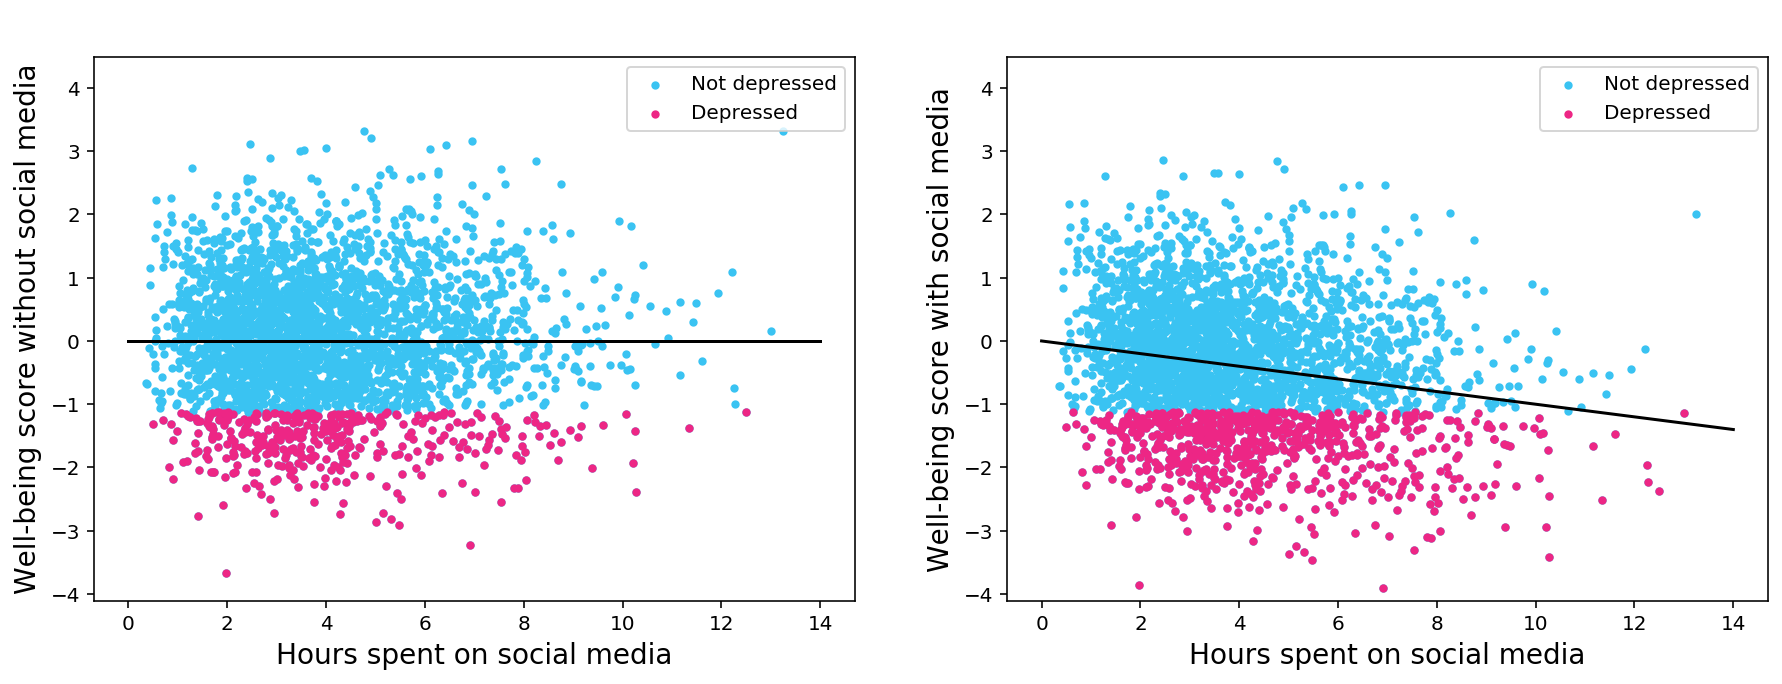

In [206]:
fig, axes = plt.subplots(1, 2, figsize=[15, 5])
plt.sca(axes[0])
make_scatter(df, 'baseline_score', ylabel='Well-being score without social media', beta=0)
plt.sca(axes[1])
make_scatter(df, 'new_score', ylabel='Well-being score with social media', beta=BETA)

### Animation
Can create a GIF with ImageMagick
```
convert -delay 3 -loop 0 frames/frame*.png animation.gif
```

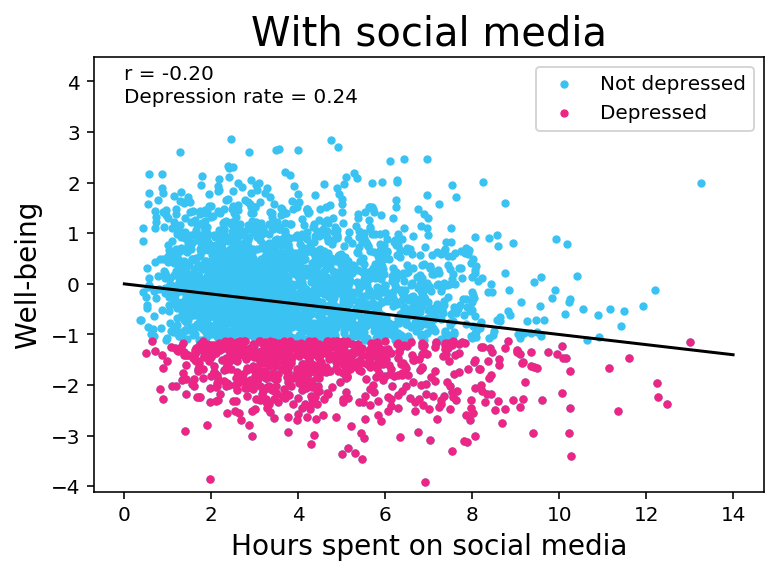

In [208]:
betas = np.concatenate([45*[0], np.linspace(0, BETA, 60), 45*[BETA]])
plt.figure()
for frame_idx, beta in enumerate(betas):
    if beta == 0:
        title = 'Without social media'
    elif beta == BETA:
        title = 'With social media'
    else:
        title = ' '
    plt.gca().clear()
    df['new_score'] = df['baseline_score'] + beta * df['hours']
    make_scatter(df, 'new_score', ylabel='Well-being', beta=beta, title=title)
    r = df[['hours', 'new_score']].corr().loc['hours', 'new_score']
    dep_rate = (df['new_score'] < cutoff).mean()
    plt.text(0, mx_score * 0.90, f'r = {r:.2f}')
    plt.text(0, mx_score * 0.80, f'Depression rate = {dep_rate:.2f}')
    plt.savefig(f'frames/frame_{frame_idx:03d}.png', dpi=200)